In [1]:
!pip install tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 30.2 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [2]:
import tensorflow as tf
import keras
import tensorflow_addons as tfa
from keras.models import Model
from keras.layers import Dense, Conv1D, LSTM, Input, Dropout, MaxPooling1D, Flatten, Reshape
from keras.optimizers.schedules import ExponentialDecay
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from pickle import dump, load
import math
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import seaborn as sn
from sklearn.metrics import f1_score

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
drive_dir = '/content/drive/MyDrive/Exoplanet Hunting/'

# Get and Preprocess Data

In [5]:
exoTrain = pd.read_csv(drive_dir+'exoTrain.csv')
exoTest = pd.read_csv(drive_dir+'exoTest.csv')

exoTrain.head(10)

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
5,2,211.10,163.57,179.16,187.82,188.46,168.13,203.46,178.65,166.49,...,-98.45,30.34,30.34,29.62,28.80,19.27,-43.90,-41.63,-52.90,-16.16
6,2,9.34,49.96,33.30,9.63,37.64,20.85,4.54,22.42,10.11,...,-58.56,9.93,9.93,23.50,5.28,-0.44,10.90,-11.77,-9.25,-36.69
7,2,238.77,262.16,277.80,190.16,180.98,123.27,103.95,50.70,59.91,...,-72.48,31.77,31.77,53.48,27.88,95.30,48.86,-10.62,-112.02,-229.92
8,2,-103.54,-118.97,-108.93,-72.25,-61.46,-50.16,-20.61,-12.44,1.48,...,43.92,7.24,7.24,-7.45,-18.82,4.53,21.95,26.94,34.08,44.65
9,2,-265.91,-318.59,-335.66,-450.47,-453.09,-561.47,-606.03,-712.72,-685.97,...,3671.03,2249.28,2249.28,2437.78,2584.22,3162.53,3398.28,3648.34,3671.97,3781.91


In [6]:
print(exoTrain['LABEL'].value_counts())
print(exoTest['LABEL'].value_counts())

LABEL
1    5050
2      37
Name: count, dtype: int64
LABEL
1    565
2      5
Name: count, dtype: int64


In [7]:
def flux_graph(dataset, row, dataframe, planet):
    if dataframe:
        fig = plt.figure(figsize=(20,5), facecolor=(.18, .31, .31))
        ax = fig.add_subplot()
        ax.set_facecolor('#004d4d')
        ax.set_title(planet, color='white', fontsize=22)
        ax.set_xlabel('time', color='white', fontsize=18)
        ax.set_ylabel('flux_' + str(row), color='white', fontsize=18)
        ax.grid(False)
        flux_time = list(dataset.columns)
        flux_values = dataset[flux_time].iloc[row]
        ax.plot([i + 1 for i in range(dataset.shape[1])], flux_values, '#00f000')
        ax.tick_params(colors = 'black', labelcolor='#00ffff', labelsize=14)
        plt.show()
    else:
        fig = plt.figure(figsize=(20,5), facecolor=(.18, .31, .31))
        ax = fig.add_subplot()
        ax.set_facecolor('#004d4d')
        ax.set_title(planet, color='white', fontsize=22)
        ax.set_xlabel('time', color='white', fontsize=18)
        ax.set_ylabel('flux_' + str(row), color='white', fontsize=18)
        ax.grid(False)
        flux_values = dataset[row]
        ax.plot([i + 1 for i in range(dataset.shape[1])], flux_values, '#00f000')
        ax.tick_params(colors = 'black', labelcolor='#00ffff', labelsize=14)
        plt.show()

In [8]:
def show_graph(dataframe, dataset):
    with_planet = exoTrain[exoTrain['LABEL'] == 2].head(3).index
    wo_planet = exoTrain[exoTrain['LABEL'] == 1].head(3).index

    for row in with_planet:
        flux_graph(dataset, row, dataframe, planet = 'with_planet')
    for row in wo_planet:
        flux_graph(dataset, row, dataframe, planet = 'wo_planet')

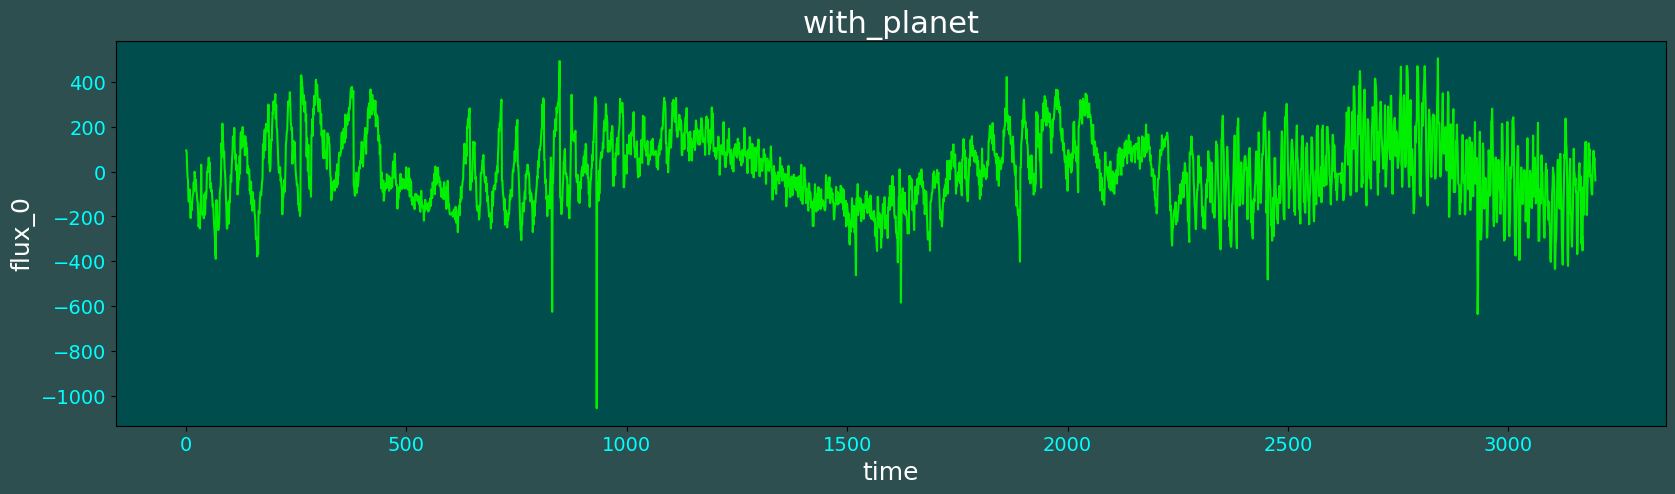

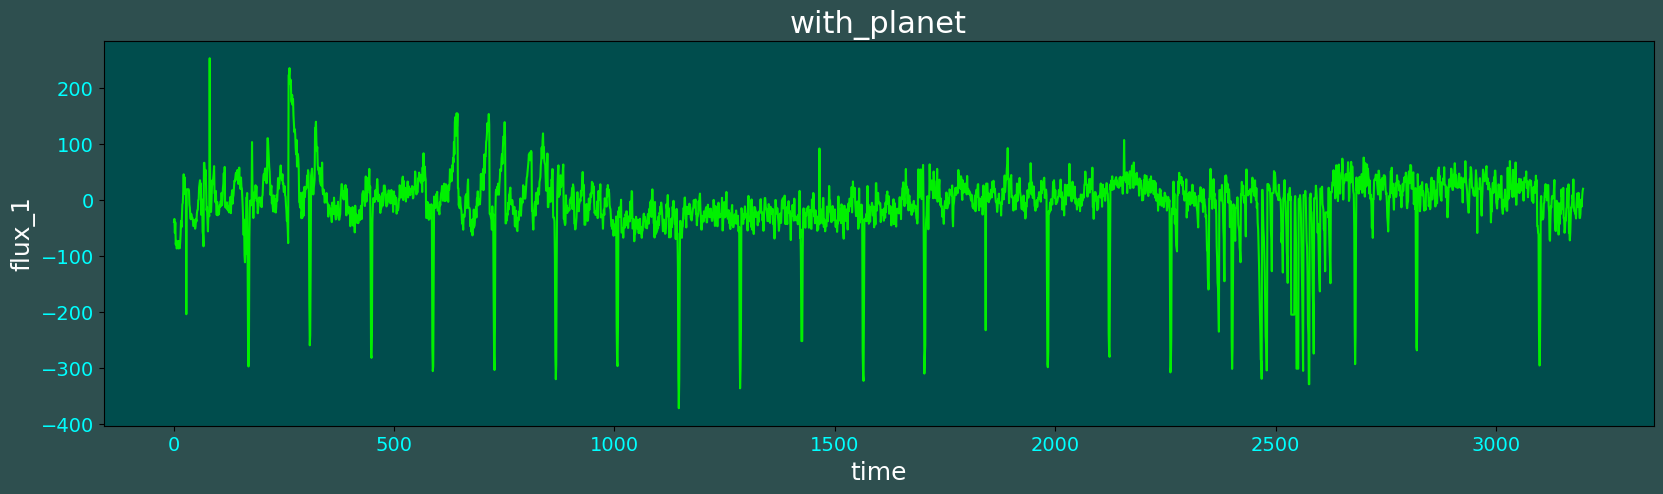

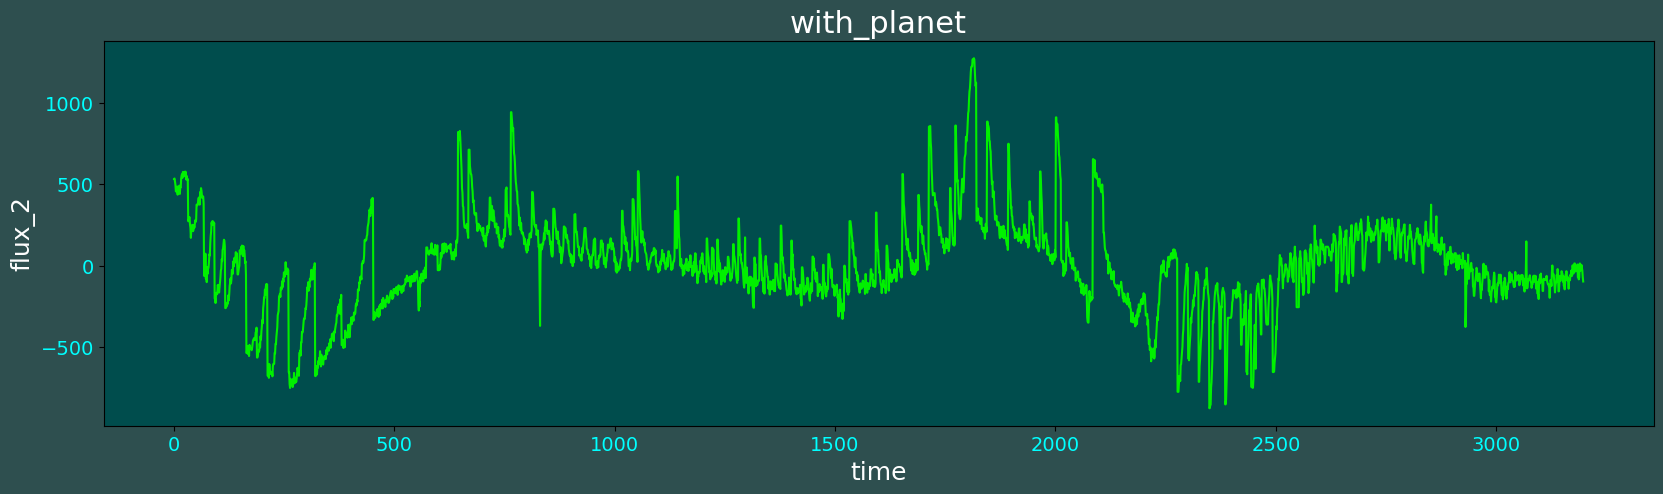

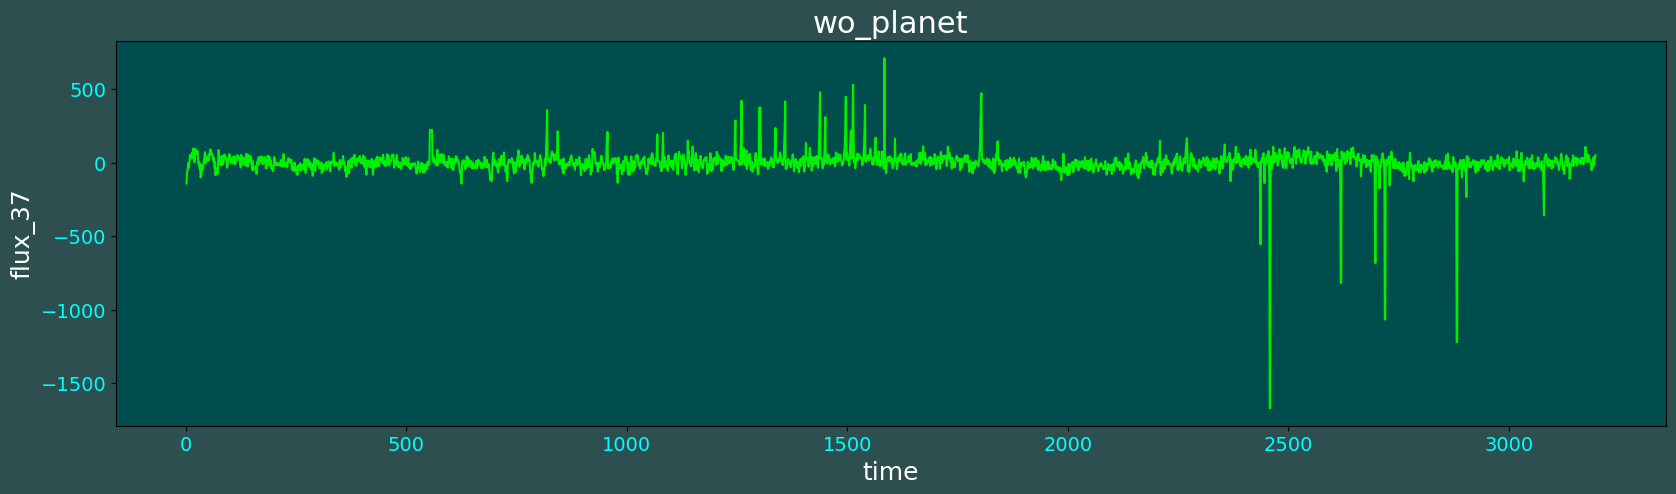

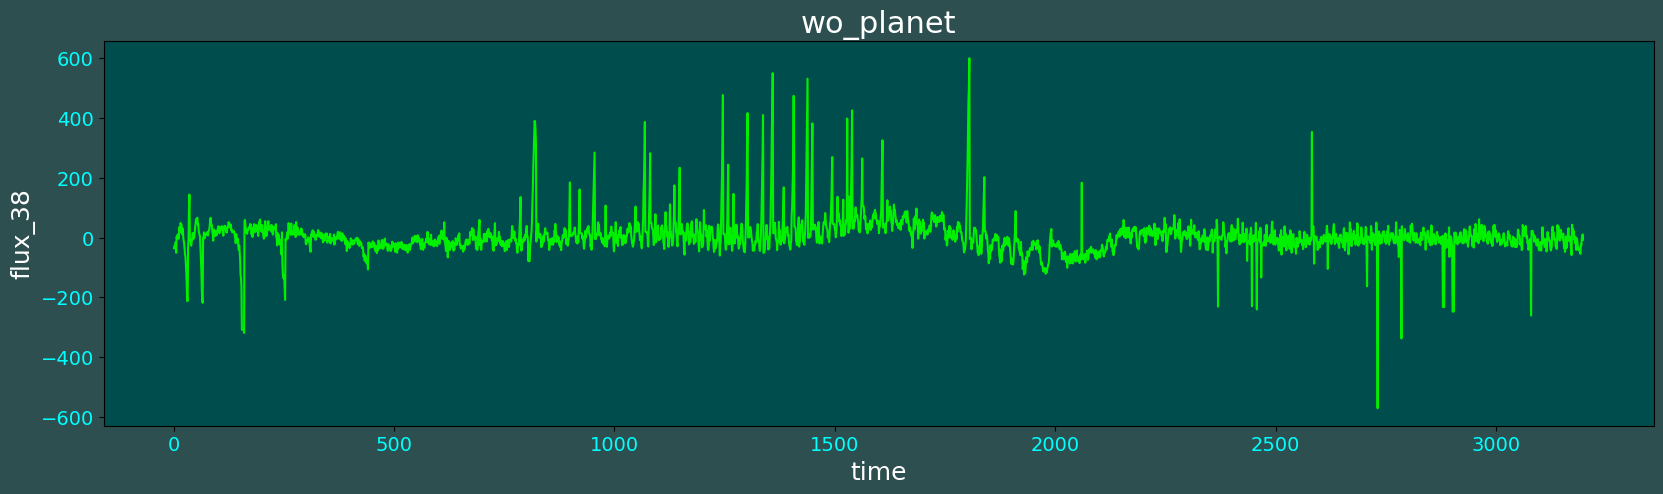

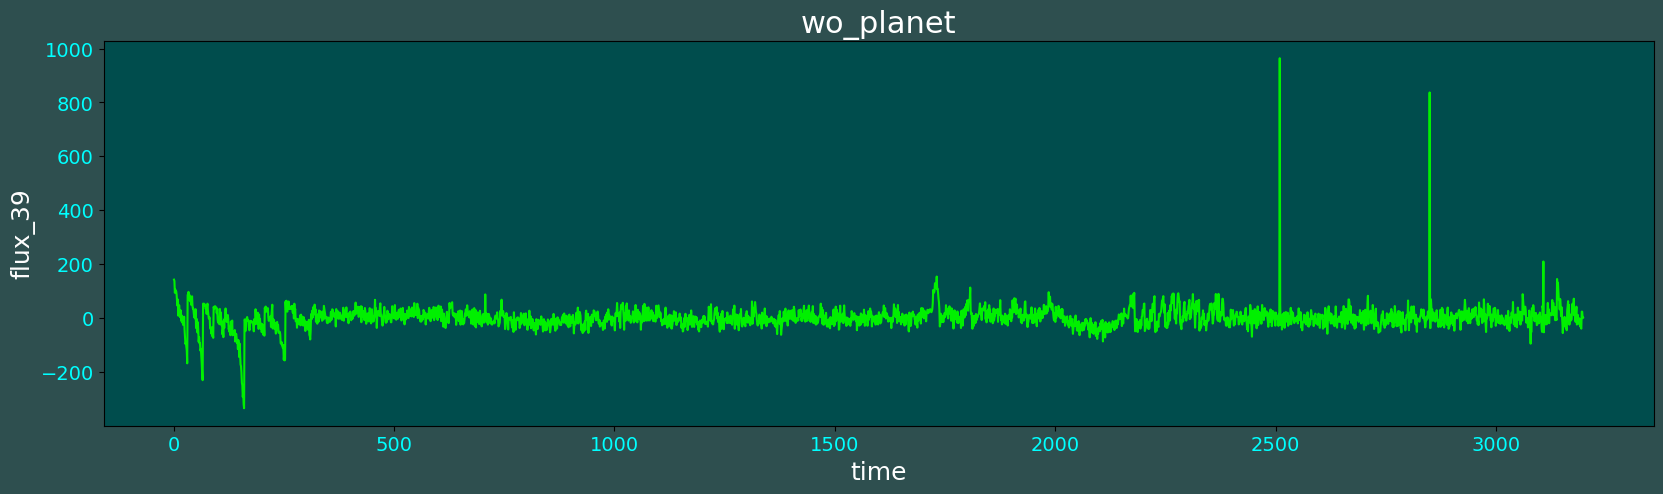

In [9]:
show_graph(True, dataset = exoTrain.loc[:, exoTrain.columns != 'LABEL'])

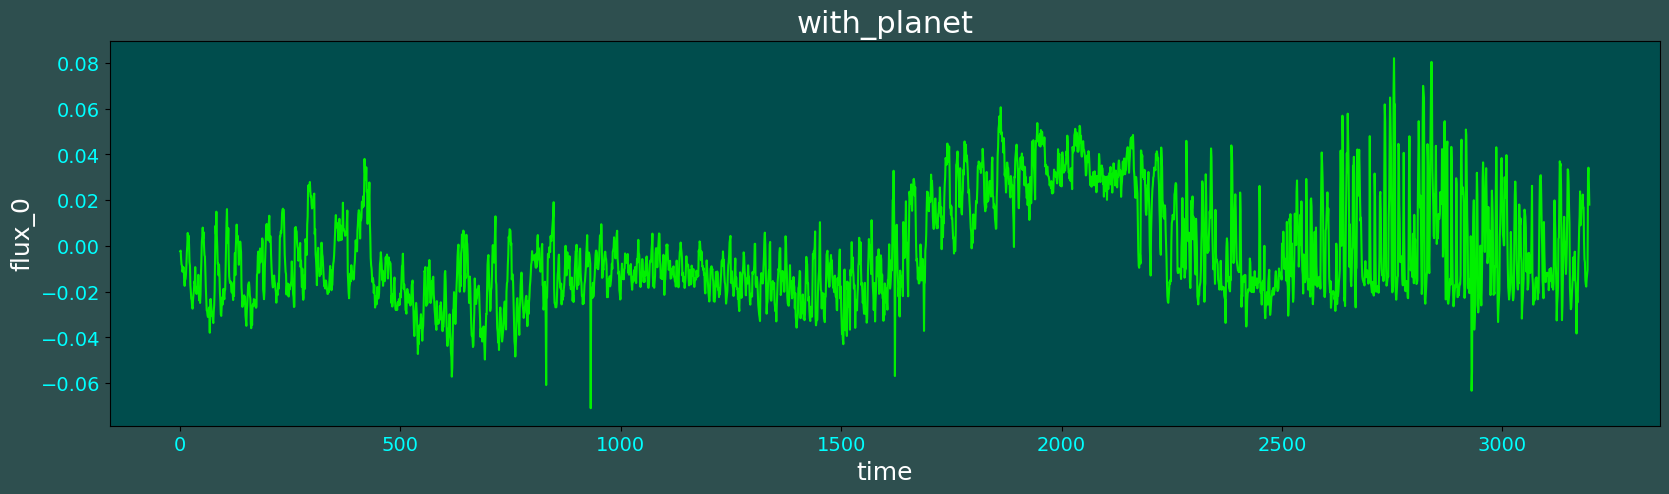

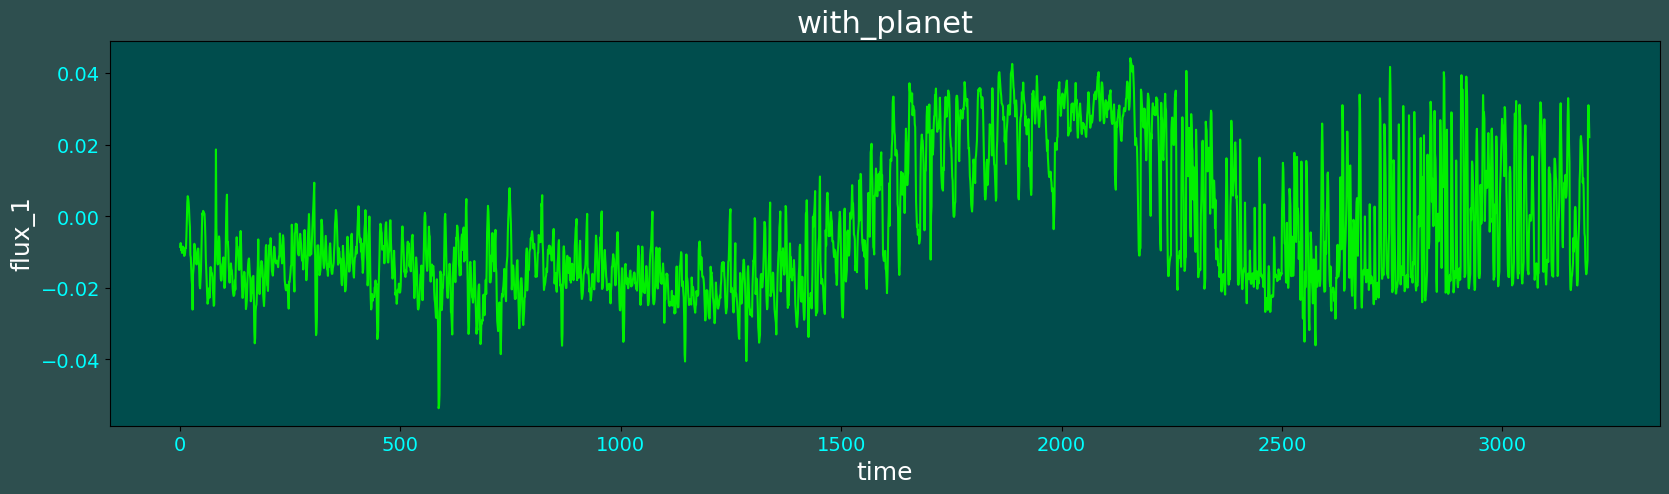

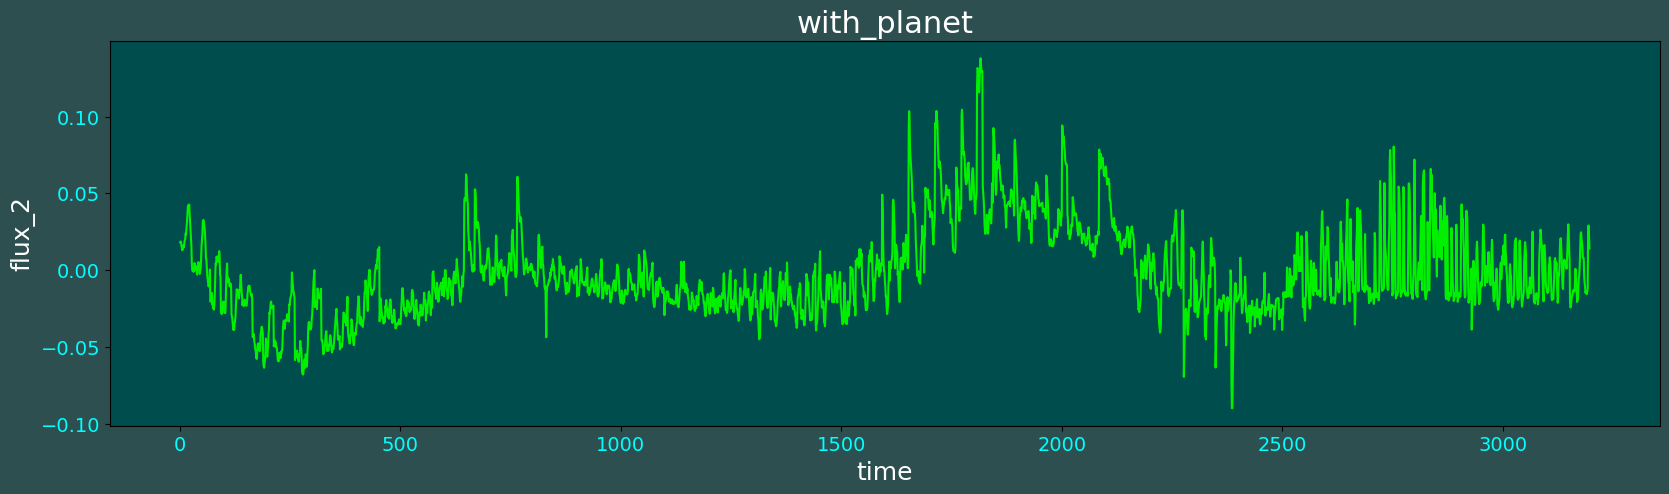

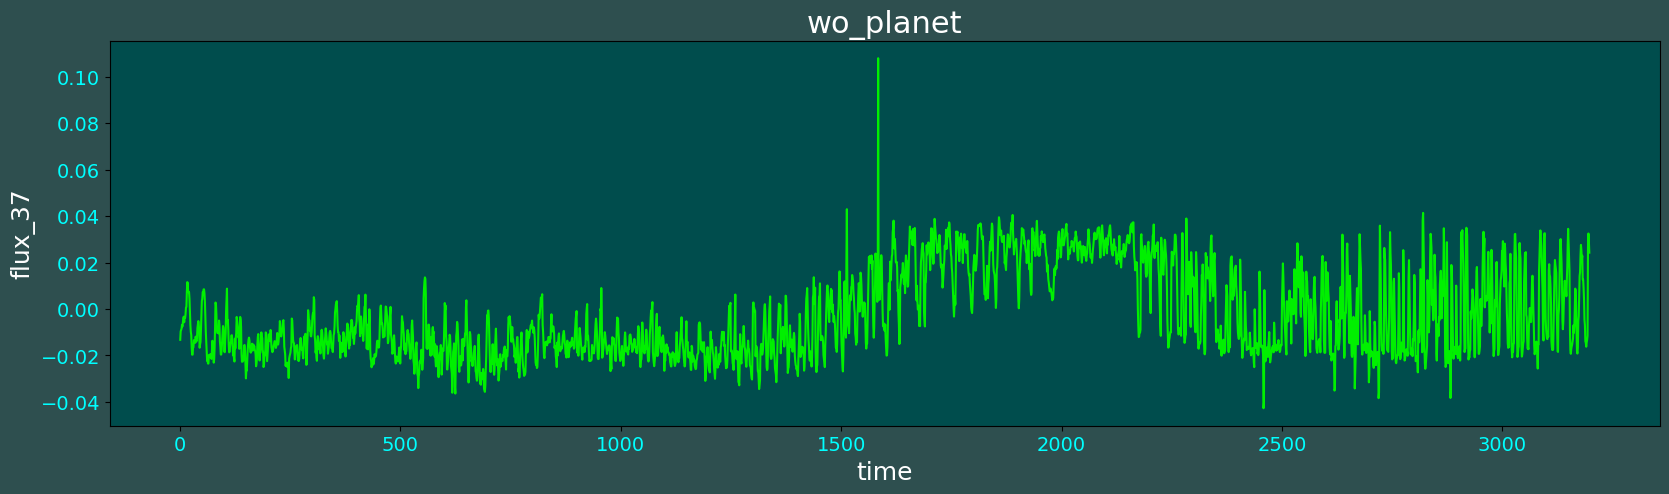

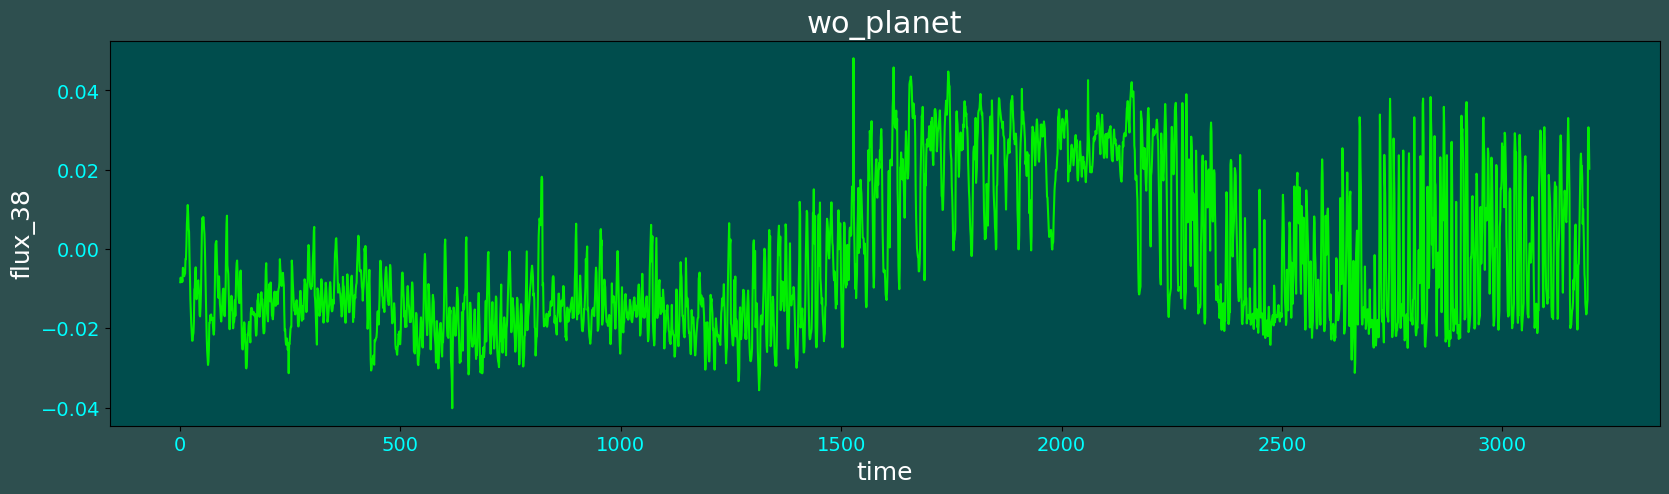

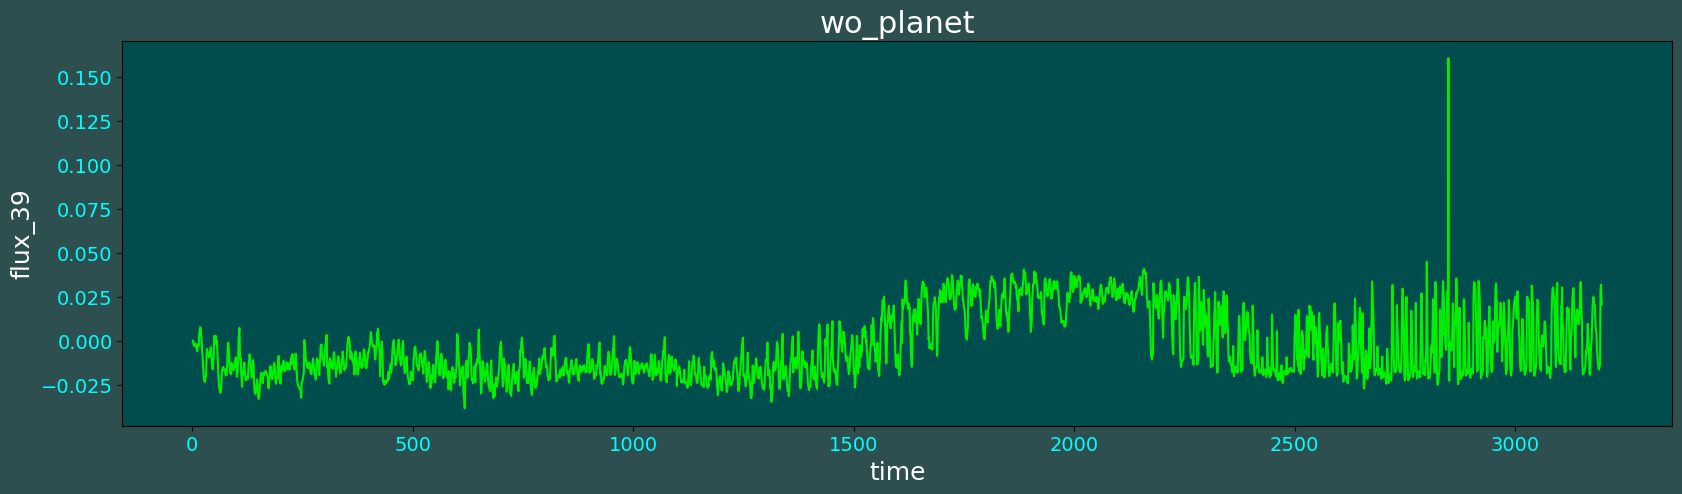

In [10]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(exoTrain.loc[:, exoTrain.columns != 'LABEL'])
show_graph(False, scaled_data)

In [11]:
scaled_data = scaler.transform(exoTest.loc[:, exoTest.columns != 'LABEL'])

In [12]:
dump(scaler, open(drive_dir+'scaler.pkl', 'wb'))

In [13]:
def deal_with_outliers(data, n=2):
    data2 = data
    for i in range(n):
        for i, r in data2.iterrows():
            values = r.values
            max_idx = values.argmax()
            min_idx = values.argmin()
            mean = values.mean()

            data2.iloc[i][max_idx] = mean

            data2.iloc[i][min_idx] = mean

    return data2

In [14]:
print(exoTrain)

      LABEL   FLUX.1   FLUX.2   FLUX.3   FLUX.4   FLUX.5   FLUX.6  FLUX.7  \
0         2    93.85    83.81    20.10   -26.98   -39.56  -124.71 -135.18   
1         2   -38.88   -33.83   -58.54   -40.09   -79.31   -72.81  -86.55   
2         2   532.64   535.92   513.73   496.92   456.45   466.00  464.50   
3         2   326.52   347.39   302.35   298.13   317.74   312.70  322.33   
4         2 -1107.21 -1112.59 -1118.95 -1095.10 -1057.55 -1034.48 -998.34   
...     ...      ...      ...      ...      ...      ...      ...     ...   
5082      1   -91.91   -92.97   -78.76   -97.33   -68.00   -68.24  -75.48   
5083      1   989.75   891.01   908.53   851.83   755.11   615.78  595.77   
5084      1   273.39   278.00   261.73   236.99   280.73   264.90  252.92   
5085      1     3.82     2.09    -3.29    -2.88     1.66    -0.75    3.85   
5086      1   323.28   306.36   293.16   287.67   249.89   218.30  188.86   

       FLUX.8  FLUX.9  ...  FLUX.3188  FLUX.3189  FLUX.3190  FLUX.3191  \
0

In [15]:
x_train = exoTrain.loc[:, exoTrain.columns != 'LABEL']
y_train = exoTrain.loc[:, 'LABEL']

In [16]:
x_test =  exoTest.loc[:, exoTest.columns != 'LABEL']
y_test = exoTest.loc[:, 'LABEL']

In [17]:
def smote(x_train, y_train):
    over = SMOTE(sampling_strategy=0.2)
    under = RandomUnderSampler(sampling_strategy=0.3)
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)
    x_train_res, y_train_res = pipeline.fit_resample(x_train, y_train)

    return x_train_res, y_train_res

In [18]:
x_train = deal_with_outliers(x_train)

In [19]:
x_train, y_train = smote(x_train, y_train)

In [20]:
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)

In [21]:
y_train = (y_train == 2) + 0
y_test = (y_test == 2) + 0

In [22]:
random.shuffle(x_train)
random.shuffle(y_train)
random.shuffle(x_test)
random.shuffle(y_test)

In [23]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(4376, 3197)
(4376,)
(570, 3197)
(570,)


In [24]:
print(np.sum(y_train)/y_train.shape[0])

0.23080438756855576


In [25]:
np.save(drive_dir+'x_train.npy', x_train)
np.save(drive_dir+'y_train.npy', y_train)

np.save(drive_dir+'x_test.npy', x_test)
np.save(drive_dir+'y_test.npy', y_test)

# Make Models

In [26]:
x_train = np.load(drive_dir+'x_train.npy')
y_train = np.load(drive_dir+'y_train.npy')

x_test = np.load(drive_dir+'x_test.npy')
y_test = np.load(drive_dir+'y_test.npy')

In [27]:
input_shape = x_train.shape[1]
output_shape = 1

In [28]:
focal_loss = tfa.losses.SigmoidFocalCrossEntropy()

In [29]:
def evaluate(model, x, y):
  y_pred = model.predict(x)
  print(classification_report(y, y_pred))
  df = pd.DataFrame(confusion_matrix(y, y_pred))
  df.columns = ['Predicted 0', 'Predicted 1']
  display(df)

In [30]:
def CNN(num_convs=1, input_shape=input_shape, output_shape=output_shape):
  input = Input(shape=input_shape, name='input')
  model = Reshape((input_shape, 1), input_shape=(input_shape,), name='reshape')(input)
  for i in range(num_convs):
    model = Conv1D(15, kernel_size=2, activation='relu', kernel_regularizer='l2', name=f'conv1d_{i+1}')(model)
    model = MaxPooling1D(2, 2, name=f'max_pooling1d_{i+1}')(model)
    if i % 2 == 0:
      model = Dropout(0.2, name=f'dropout_{i+1}')(model)
  model = Flatten()(model)
  model = Dense(50, activation="relu", name='dense_1')(model)
  model = Dropout(0.5, name=f'dropout_{num_convs+1}')(model)
  model = Dense(20, activation="relu", name='dense_2')(model)
  model = Dense(output_shape, activation="sigmoid", name='output')(model)
  model = Model(input, model)
  lr_schedule = ExponentialDecay(initial_learning_rate=1e-2, decay_steps=10000, decay_rate=0.94)
  model.compile(optimizer = Adam(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [31]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

In [32]:
epochs = 30
batch_size = 64

In [33]:
# Train and save the best CNN
best_cnn = None
best_loss = None
best_cnn_history = None
for i in range(1, 11): # i = number of conv layers
  cnn = CNN(i)
  history = cnn.fit(x_train, y_train, validation_split=0.22, batch_size=batch_size, callbacks=[early_stop], epochs=epochs, verbose=2)
  cnn.save(f'cnn_{i}')
  if best_cnn == None:
    best_cnn = f"cnn_{i}"
    best_loss = min(history.history['val_loss'])
    best_cnn_history = history
    continue
  if min(history.history['val_loss']) < best_loss:
    best_cnn = f"cnn_{i}"
    best_loss = min(history.history['val_loss'])
    best_cnn_history = history
    continue

Epoch 1/30
54/54 - 5s - loss: 842.5425 - accuracy: 0.6645 - val_loss: 224.8399 - val_accuracy: 0.7674 - 5s/epoch - 98ms/step
Epoch 2/30
54/54 - 0s - loss: 2.1224 - accuracy: 0.7644 - val_loss: 0.5724 - val_accuracy: 0.7684 - 319ms/epoch - 6ms/step
Epoch 3/30
54/54 - 0s - loss: 0.6510 - accuracy: 0.7650 - val_loss: 0.8236 - val_accuracy: 0.7601 - 307ms/epoch - 6ms/step
Epoch 4/30
54/54 - 0s - loss: 5.5192 - accuracy: 0.7674 - val_loss: 0.5877 - val_accuracy: 0.7684 - 315ms/epoch - 6ms/step
Epoch 5/30
54/54 - 0s - loss: 2.1701 - accuracy: 0.7694 - val_loss: 0.5452 - val_accuracy: 0.7684 - 309ms/epoch - 6ms/step
Epoch 6/30
54/54 - 0s - loss: 0.5442 - accuracy: 0.7694 - val_loss: 0.5452 - val_accuracy: 0.7684 - 314ms/epoch - 6ms/step
Epoch 7/30
54/54 - 0s - loss: 0.5441 - accuracy: 0.7694 - val_loss: 0.5452 - val_accuracy: 0.7684 - 316ms/epoch - 6ms/step
Epoch 8/30
54/54 - 0s - loss: 0.5442 - accuracy: 0.7694 - val_loss: 0.5452 - val_accuracy: 0.7684 - 308ms/epoch - 6ms/step
Epoch 9/30
54/

In [34]:
model = keras.Sequential()
model.add(Reshape((input_shape, 1), input_shape=(input_shape,)))
model.add(LSTM(32, activation='relu', return_sequences=True, input_shape=(input_shape, 1), dropout = 0.3))
model.add(LSTM(16, activation='relu'))
model.add(Dense(1))

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics = ['acc']
)

print(model.summary())

model.fit(x = x_train,
              y = y_train,
              epochs = 3,
              validation_split=0.2,
              batch_size = 100
         )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 3197, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 3197, 32)          4352      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 7505 (29.32 KB)
Trainable params: 7505 (29.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/3
35/35 [==============================] - 159s 4s/step - loss: nan - acc: 0.7677 - val_loss: nan - val_acc: 0.7740
Epoch 2/3
35/35 [========

In [35]:
cnn.save(drive_dir+'cnn_tmp')

In [36]:
print(best_cnn)

cnn_1


In [39]:
g# best cnn
cnn = CNN(1)
cnn.fit(x_train, y_train, validation_split=0.22, batch_size=batch_size, callbacks=[early_stop], epochs=epochs, verbose=2)
cnn.save(drive_dir+"cnn")

Epoch 1/30
54/54 - 2s - loss: 1940.0564 - accuracy: 0.6062 - val_loss: 252.3278 - val_accuracy: 0.7529 - 2s/epoch - 35ms/step
Epoch 2/30
54/54 - 0s - loss: 465.5791 - accuracy: 0.6704 - val_loss: 367.0061 - val_accuracy: 0.7684 - 340ms/epoch - 6ms/step
Epoch 3/30
54/54 - 0s - loss: 54.9712 - accuracy: 0.7032 - val_loss: 0.7195 - val_accuracy: 0.7622 - 320ms/epoch - 6ms/step
Epoch 4/30
54/54 - 0s - loss: 0.5981 - accuracy: 0.7694 - val_loss: 0.5610 - val_accuracy: 0.7684 - 319ms/epoch - 6ms/step
Epoch 5/30
54/54 - 0s - loss: 0.6523 - accuracy: 0.7697 - val_loss: 0.5491 - val_accuracy: 0.7684 - 307ms/epoch - 6ms/step
Epoch 6/30
54/54 - 0s - loss: 0.6071 - accuracy: 0.7691 - val_loss: 0.5476 - val_accuracy: 0.7684 - 313ms/epoch - 6ms/step
Epoch 7/30
54/54 - 0s - loss: 0.6072 - accuracy: 0.7691 - val_loss: 0.5475 - val_accuracy: 0.7684 - 311ms/epoch - 6ms/step
Epoch 8/30
54/54 - 0s - loss: 0.5597 - accuracy: 0.7694 - val_loss: 0.5475 - val_accuracy: 0.7684 - 308ms/epoch - 6ms/step
Epoch 9/